In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX for all text
    "font.family": "serif",       # Use serif font (LaTeX default)
    "font.size": 20,              # Font size
})

In [2]:
# Parameters
N = 512               # grid points per dimension
L = 10                # domain size [-L, L]^2
T = 1.0                # final time
dt = 1e-2              # time step
nsteps = int(T / dt)

In [3]:
def plot(omega, save=False, filename="", title=""):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    skip = 3
    ax.plot_surface(X, Y, omega, cmap='inferno', edgecolor='none', antialiased=True)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$\omega$")
    if title: ax.set_title(title)

    if save:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [4]:
# SPATIAL GRID
x = np.linspace(-L/2, L/2, N, endpoint=False)
y = np.linspace(-L/2, L/2, N, endpoint=False)

X, Y = np.meshgrid(x, y, indexing='ij')

kx = np.fft.fftfreq(N) * N
ky = np.fft.fftfreq(N) * N
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2 # |k|^2
K2[0,0] = 1.0

def R1_sq(f):
    """Compute R1^2 f using FFT."""
    f_hat = np.fft.fft2(f)
    symbol = -(KX**2 / K2) # symbol of R1^2
    symbol[0,0] = 0.0
    out = np.fft.ifft2(symbol * f_hat).real
    return out


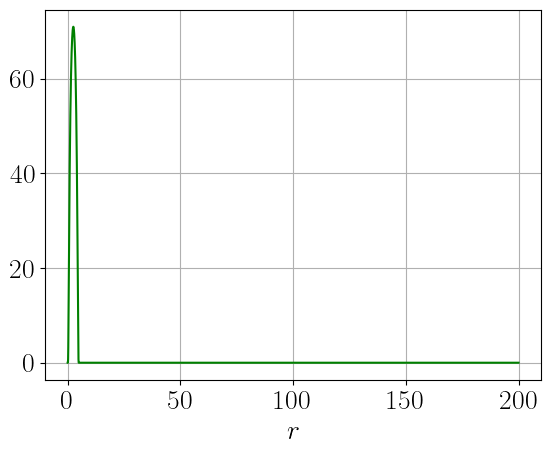

In [5]:
# RADIAL INITIAL CONDITION
alpha = 0.01
a = 1.0
b = 1.0

# W2
mult = 20
r = np.linspace(1e-12, mult * L, mult * N)

def compute_W2(r, alpha): return r ** (alpha - 1) / (1 + r ** (2 * alpha))

W2 = compute_W2(r, alpha)

# W1
def compute_W1(r, alpha, a, b): return a * np.arctan(r ** alpha) / (alpha * r) # approximation for small alpha
def compute_W1_arr(r, alpha, a, b): return np.array([compute_W1(ri, alpha, a, b) for ri in r])

W1 = compute_W1_arr(r, alpha, a, b)

def exp_inv(r):
    return np.array([np.exp(- 1 / ri) if ri > 0 else 0.0 for ri in r])

F0 = exp_inv(r) * exp_inv(5 - r) * np.arctan(r ** alpha) * (1 + r ** (2 * alpha)) / r ** (alpha) / alpha 
F02 = exp_inv(r) * exp_inv(5 - r)

# plot
# plt.plot(r[W1 < 10], W1[W1 < 10], 'b-', label=r"$W_1(r)$")
# plt.plot(r[W2 < 10], W2[W2 < 10], 'r-', label=r"$W_2(r)$")
plt.plot(r, F0, 'g-')
# plt.plot(r, F02, 'm-')
# plt.plot(r, np.exp(- 1 / r), 'g-')
# plt.xlim(0, 1e-12)
plt.grid()
plt.xlabel(r"$r$")
plt.show()

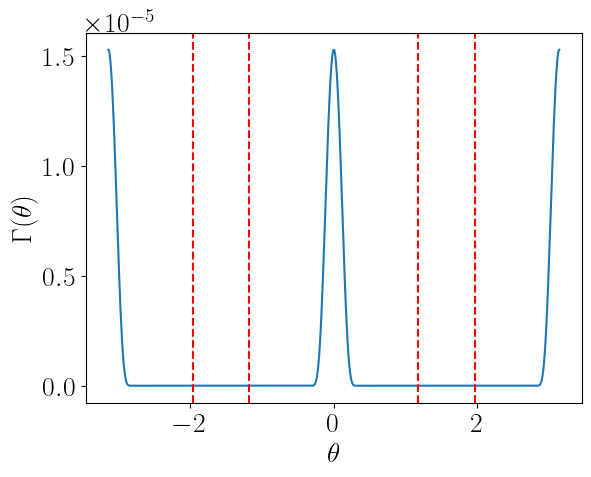

In [33]:
# ANGULAR INITIAL CONDITION
def smooth_bump(theta, M = 1e6, a = 3 * np.pi / 8, b = 5 * np.pi / 8):
    """Smooth bump supported in [a,b], zero outside."""
    # theta = np.mod(theta, np.pi)
    out = np.zeros_like(theta)
    theta_here = (theta + np.pi/2) % (np.pi)
    mask = (theta_here > a) & (theta_here < b)
    t = (theta_here[mask] - a) * (b - theta_here[mask]) # vanishes at boundaries
    out[mask] = np.exp(-1.0 / t) * M
    return out

plt.plot(np.linspace(-np.pi, np.pi, 1000), smooth_bump(np.linspace(-np.pi, np.pi, 1000), M=1e-2))
plt.axvline(3 * np.pi / 8, color='r', linestyle='--')
plt.axvline(5 * np.pi / 8, color='r', linestyle='--')
plt.axvline(-3 * np.pi / 8, color='r', linestyle='--')
plt.axvline(-5 * np.pi / 8, color='r', linestyle='--')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\Gamma(\theta)$")
plt.show()

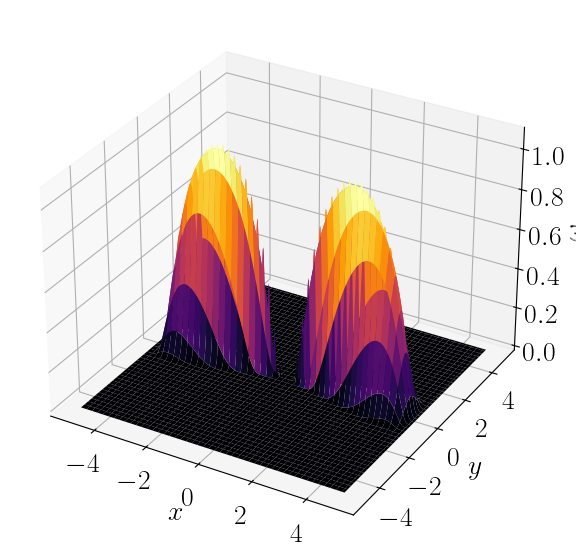

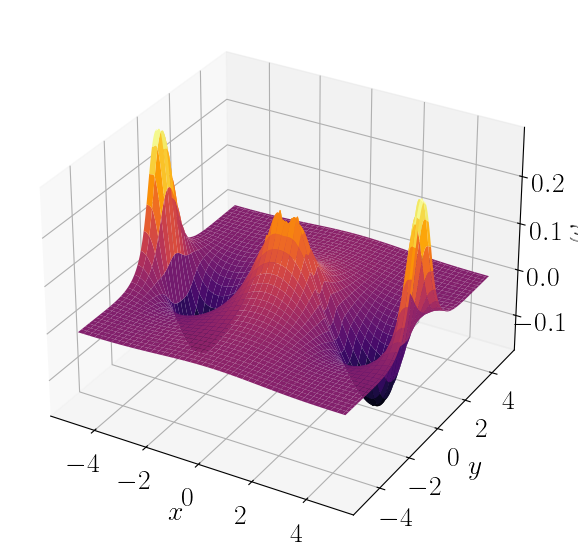

In [34]:
# FULL INITIAL CONDITION
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)
F0_2d = np.interp(R, r, F0, left=0, right=0)
Gamma_2d = smooth_bump(Theta, M=1e1)
omega0 = F0_2d * Gamma_2d
plot(omega0)

plot(R1_sq(omega0))

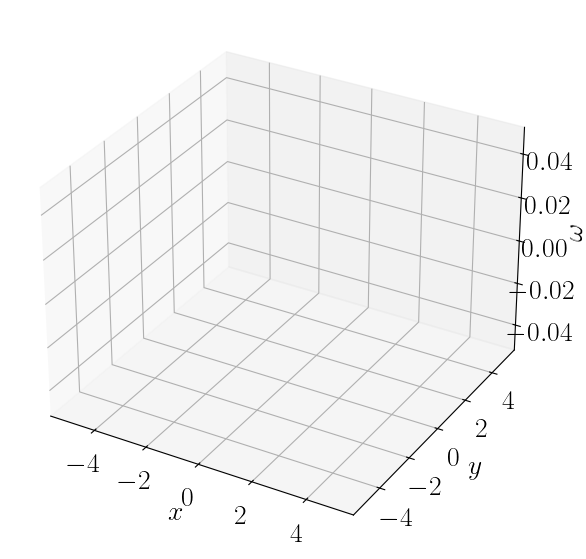

KeyboardInterrupt: 

In [37]:
omega = omega0.copy()
T = 300
dt = 1
nsteps = int(T / dt)

k_cut = N / 3.0
dealias_mask = np.abs(K2) <= k_cut

def get_rhs(w):
    nonlin = w * R1_sq(w)
    nonlin_hat = np.fft.fft2(nonlin)
    nonlin_hat[~dealias_mask] = 0.0
    nonlin = np.real(np.fft.ifft2(nonlin_hat))

    return nonlin, np.max(np.abs(nonlin))

maxs = []
maxs_rhs = []
rk4 = True
for n in range(nsteps):
    if rk4:
        k1, _ = get_rhs(omega)
        k2, _ = get_rhs(omega + 0.5 * dt * k1)
        k3, _ = get_rhs(omega + 0.5 * dt * k2)
        k4, _ = get_rhs(omega + dt * k3)

        omega += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    else:
        a1, a2 = get_rhs(omega)
        omega += a1 * dt
        maxs_rhs.append(a2)


    maxs.append(np.max(np.abs(omega)))
    if (n + 1) % 10 == 0:
        print(f"Step {n + 1}/{nsteps}")
        print(np.max(np.abs(omega)))
        clear_output(wait=True)
        plot(omega) #, save=True, filename=f"plots/2d/R12_R{"_rk4"*rk4}/R12_step_{n+1}.pdf")
        # plot(omega, save=True, filename=f"plots/2d/R12_R{"_rk4"*rk4}/time/R12_step_{n+1}_with_timestamp.pdf", title=rf"$t={(n + 1) * dt:.2f}$")

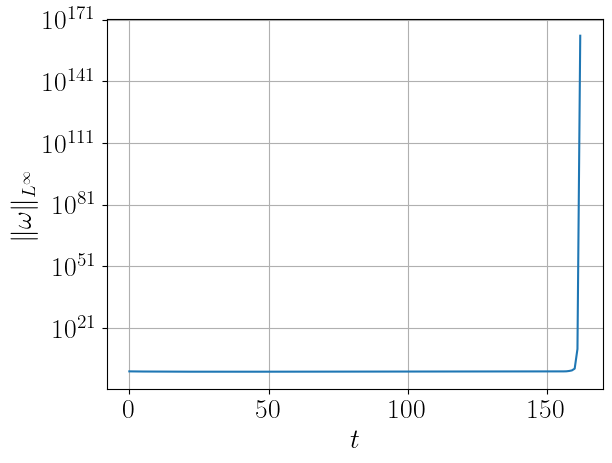

In [39]:
plt.plot(maxs[:])
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$\|\omega\|_{L^{\infty}}$")
plt.yscale('log')
# plt.savefig(f"plots/2d/R12_R{"_rk4"*rk4}/R12_max_omega.pdf", bbox_inches='tight')
plt.show()

# plt.plot(maxs_rhs)
# plt.show()
# print(np.max(maxs_rhs))